# Model Comparison Notebook

Compare performance of different model checkpoints side-by-side.

In [11]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import cv2

# Add project root to path (go up one level from scripts/)
project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.yolo_like import Model
from datasets.target_encoding import load_yolo_labels
from datasets.transforms import letterbox_image
from eval.evaluator import ObjectDetectionEvaluator, evaluate_predictions

print("All imports successful!")

All imports successful!


In [12]:
# Helper functions for evaluation (from scripts/evaluate.py)

def decode_predictions(pred_grid, conf_thresh=0.5, grid_size=13, img_size=416):
    """Decode grid predictions [S, S, 5] to bounding boxes."""
    S = grid_size
    boxes = []

    for j in range(S):
        for i in range(S):
            tx = pred_grid[j, i, 0].item()
            ty = pred_grid[j, i, 1].item()
            tw = pred_grid[j, i, 2].item()
            th = pred_grid[j, i, 3].item()
            obj_conf = pred_grid[j, i, 4].item()

            if obj_conf < conf_thresh:
                continue

            cx = (i + tx) / S
            cy = (j + ty) / S
            w = tw
            h = th

            cx_pix = cx * img_size
            cy_pix = cy * img_size
            w_pix = w * img_size
            h_pix = h * img_size

            x1 = cx_pix - w_pix / 2
            y1 = cy_pix - h_pix / 2
            x2 = cx_pix + w_pix / 2
            y2 = cy_pix + h_pix / 2

            boxes.append((x1, y1, x2, y2, obj_conf))

    return boxes


def compute_iou(box1, box2):
    """Compute IoU between two boxes (x1, y1, x2, y2, conf)."""
    x1_1, y1_1, x2_1, y2_1, _ = box1
    x1_2, y1_2, x2_2, y2_2, _ = box2

    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0

    inter_area = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0.0


def nms(boxes, iou_thresh=0.5):
    """Apply Non-Maximum Suppression."""
    if len(boxes) == 0:
        return []

    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    keep = []

    while len(boxes) > 0:
        best = boxes[0]
        keep.append(best)
        boxes = boxes[1:]

        filtered = []
        for box in boxes:
            iou = compute_iou(best, box)
            if iou < iou_thresh:
                filtered.append(box)
        boxes = filtered

    return keep


def infer_image(model, image_path, device, img_size=416, grid_size=13,
                conf_thresh=0.5, iou_thresh=0.5):
    """Run inference on a single image."""
    img_tensor, params = letterbox_image(image_path, (img_size, img_size))
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)

    boxes = decode_predictions(pred[0], conf_thresh, grid_size, img_size)
    boxes = nms(boxes, iou_thresh)

    return boxes, params


def transform_boxes_to_original(boxes, params, img_size=416):
    """Transform boxes from letterbox coordinates to original image coordinates."""
    if len(boxes) == 0:
        return []

    scale = params['scale']
    pad_w = params['pad_w']
    pad_h = params['pad_h']
    orig_w, orig_h = params['orig_wh']

    transformed = []
    for (x1, y1, x2, y2, conf) in boxes:
        x1_no_pad = x1 - pad_w
        y1_no_pad = y1 - pad_h
        x2_no_pad = x2 - pad_w
        y2_no_pad = y2 - pad_h

        x1_orig = x1_no_pad / scale
        y1_orig = y1_no_pad / scale
        x2_orig = x2_no_pad / scale
        y2_orig = y2_no_pad / scale

        x1_orig = max(0, min(x1_orig, orig_w))
        y1_orig = max(0, min(y1_orig, orig_h))
        x2_orig = max(0, min(x2_orig, orig_w))
        y2_orig = max(0, min(y2_orig, orig_h))

        transformed.append((x1_orig, y1_orig, x2_orig, y2_orig, conf))

    return transformed


def evaluate_dataset(model, image_dir, label_dir, device, img_size=416,
                    grid_size=13, conf_thresh=0.5, iou_thresh=0.5,
                    max_images=None):
    """Evaluate model on all images in a directory."""
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))

    if max_images:
        image_paths = image_paths[:max_images]

    all_predictions = []
    all_ground_truth = []
    image_ids = []
    stats = {
        'total': 0,
        'processed': 0,
        'errors': 0,
        'images_with_objects': 0,
        'total_pred_objects': 0,
        'total_gt_objects': 0,
    }

    print(f"\nEvaluating {len(image_paths)} images...")
    print("-" * 70)

    for idx, img_path in enumerate(image_paths):
        stats['total'] += 1

        try:
            basename = os.path.basename(img_path)
            label_name = os.path.splitext(basename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_name)

            gt_boxes = load_yolo_labels(label_path)
            if len(gt_boxes) > 0:
                stats['images_with_objects'] += 1
            stats['total_gt_objects'] += len(gt_boxes)

            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            gt_pixel = []
            for (cx, cy, bw, bh) in gt_boxes:
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                gt_pixel.append((x1, y1, x2, y2))

            preds, params = infer_image(
                model, img_path, device, img_size, grid_size,
                conf_thresh, iou_thresh
            )

            preds_orig = transform_boxes_to_original(preds, params, img_size)

            all_predictions.append(preds_orig)
            all_ground_truth.append(gt_pixel)
            image_ids.append(basename)

            stats['processed'] += 1
            stats['total_pred_objects'] += len(preds_orig)

            if (idx + 1) % 50 == 0:
                print(f"Processed {idx + 1}/{len(image_paths)} images...")

        except Exception as e:
            stats['errors'] += 1
            print(f"Error processing {img_path}: {e}")

    print("-" * 70)
    print(f"Evaluation complete: {stats['processed']} images processed, {stats['errors']} errors")

    return all_predictions, all_ground_truth, image_ids, stats

print("Helper functions loaded!")

Helper functions loaded!


## Configuration

In [13]:
# Dataset paths (relative to project root)
VAL_IMAGES = "../data/processed/training_5/images/val"
VAL_LABELS = "../data/processed/training_5/labels/val"

# Model configuration
GRID_SIZE = 13
IMG_SIZE = 416
NUM_CLASSES = 1

# Evaluation parameters
CONF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.5
IOU_THRESHOLDS = [0.5, 0.85]

# Device
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: mps


## Model Comparison Class

In [14]:
class ModelEvaluator:
    """Evaluate and compare different model checkpoints."""
    
    def __init__(self, checkpoint_path, name, device='cpu'):
        """
        Args:
            checkpoint_path: Path to model checkpoint
            name: Descriptive name for this model
            device: Device to run evaluation on
        """
        self.checkpoint_path = checkpoint_path
        self.name = name
        self.device = device
        self.results = None
        self.checkpoint = None
        
        # Load checkpoint info
        self._load_checkpoint_info()
    
    def _load_checkpoint_info(self):
        """Load checkpoint metadata."""
        try:
            self.checkpoint = torch.load(self.checkpoint_path, map_location='cpu')
            self.val_loss = self.checkpoint.get('val_loss', 'N/A')
            self.epoch = self.checkpoint.get('epoch', 'N/A')
            self.train_losses = self.checkpoint.get('train_losses', [])
            self.val_losses = self.checkpoint.get('val_losses', [])
        except Exception as e:
            print(f"Error loading checkpoint {self.checkpoint_path}: {e}")
            self.val_loss = 'Error'
            self.epoch = 'Error'
            self.train_losses = []
            self.val_losses = []
    
    def evaluate(self, image_dir, label_dir, conf_thresh=0.5, nms_thresh=0.5, iou_thresholds=[0.5, 0.75]):
        """Run evaluation on validation set."""
        print(f"\nEvaluating {self.name}...")
        print(f"Checkpoint: {self.checkpoint_path}")
        print(f"Training - Epoch: {self.epoch}, Val Loss: {self.val_loss}")
        
        # Initialize model
        model = Model(S=GRID_SIZE)
        
        # Load weights
        if self.checkpoint is not None:
            model.load_state_dict(self.checkpoint['model'])
        model.to(self.device)
        model.eval()
        
        # Run evaluation using evaluate_dataset function
        all_preds, all_gt, image_ids, stats = evaluate_dataset(
            model, image_dir, label_dir, self.device,
            grid_size=GRID_SIZE, img_size=IMG_SIZE,
            conf_thresh=conf_thresh, iou_thresh=nms_thresh
        )
        
        # Compute metrics using evaluate_predictions
        eval_results = evaluate_predictions(
            all_preds, all_gt,
            iou_thresholds=iou_thresholds,
            verbose=False
        )
        
        # Compute mAP
        evaluator = ObjectDetectionEvaluator(iou_thresholds)
        map_scores = evaluator.compute_map(all_preds, all_gt)
        
        # Store results - eval_results is a dict of EvaluationMetrics objects
        self.results = {}
        for iou_thresh in iou_thresholds:
            iou_key = f'iou_{iou_thresh}'
            metrics = eval_results[iou_thresh]  # This is an EvaluationMetrics object
            self.results[iou_key] = {
                'precision': metrics.precision,
                'recall': metrics.recall,
                'f1': metrics.f1,
                'tp': metrics.tp,
                'fp': metrics.fp,
                'fn': metrics.fn,
                'ap': map_scores[iou_thresh]
            }
        
        self.stats = stats
        return self.results
    
    def print_summary(self):
        """Print evaluation summary."""
        if self.results is None:
            print(f"No results available for {self.name}")
            return
        
        print(f"\n{'='*70}")
        print(f"{self.name} - EVALUATION SUMMARY")
        print(f"{'='*70}")
        print(f"Checkpoint: {self.checkpoint_path}")
        print(f"Epoch: {self.epoch}, Val Loss: {self.val_loss:.4f}" if isinstance(self.val_loss, (int, float)) else f"Epoch: {self.epoch}, Val Loss: {self.val_loss}")
        print()
        
        for key, metrics in self.results.items():
            iou_val = key.replace('iou_', '')
            print(f"IoU Threshold: {iou_val}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")
            print(f"  mAP:       {metrics['ap']:.4f}")
            print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
            print()
    
    def get_metric(self, metric_name, iou_threshold=0.5):
        """Get specific metric value."""
        if self.results is None:
            return None
        key = f'iou_{iou_threshold}'
        if key in self.results:
            return self.results[key].get(metric_name, None)
        return None

## Load Validation Dataset

In [15]:
# No need to load dataset separately - ModelEvaluator handles it
print(f"Dataset paths configured:"
      f"  Images: {VAL_IMAGES}")
print(f"  Labels: {VAL_LABELS}")

Dataset paths configured:  Images: ../data/processed/training_5/images/val
  Labels: ../data/processed/training_5/labels/val


## Define Models to Compare

In [16]:
# Define models to compare
models = [
    ModelEvaluator(
        checkpoint_path="../checkpoints/best.pt",
        name="CURRENT MODEL (λ_coord=7.5, with augmentation)",
        device=DEVICE
    ),
]

print(f"Loaded {len(models)} models for comparison")

Loaded 1 models for comparison


In [17]:
# YOLOv5 Evaluator Class
class YOLOv5Evaluator:
    """Evaluate YOLOv5 model for comparison."""
    
    def __init__(self, model_path='../checkpoints/yolo/yolov5su.pt', name='YOLOv5', device='cpu'):
        """
        Args:
            model_path: Path to YOLOv5 model weights
            name: Descriptive name for this model
            device: Device to run evaluation on
        """
        self.model_path = model_path
        self.name = name
        self.device = device
        self.results = None
        self.model = None
        
    def _load_model(self):
        """Load YOLOv5 model using ultralytics package."""
        try:
            from ultralytics import YOLO
            self.model = YOLO(self.model_path)
            print(f"Loaded model from {self.model_path}")
        except Exception as e:
            print(f"Error loading YOLOv5: {e}")
            print("Install YOLOv5 with: pip install ultralytics")
            self.model = None
    
    def evaluate(self, image_dir, label_dir, conf_thresh=0.5, nms_thresh=0.5, iou_thresholds=[0.5, 0.75]):
        """Run evaluation on validation set."""
        print(f"\nEvaluating {self.name}...")
        
        # Load model if not already loaded
        if self.model is None:
            self._load_model()
        
        if self.model is None:
            print("Skipping YOLOv5 evaluation (model not available)")
            return None
        
        # Get image paths
        image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        
        all_predictions = []
        all_ground_truth = []
        
        print(f"Evaluating {len(image_paths)} images...")
        print("-" * 70)
        
        for idx, img_path in enumerate(image_paths):
            try:
                # Get label path
                basename = os.path.basename(img_path)
                label_name = os.path.splitext(basename)[0] + '.txt'
                label_path = os.path.join(label_dir, label_name)
                
                # Load ground truth
                gt_boxes = load_yolo_labels(label_path)
                
                # Convert GT to pixel coordinates
                img = cv2.imread(img_path)
                h, w = img.shape[:2]
                gt_pixel = []
                for (cx, cy, bw, bh) in gt_boxes:
                    x1 = (cx - bw / 2) * w
                    y1 = (cy - bh / 2) * h
                    x2 = (cx + bw / 2) * w
                    y2 = (cy + bh / 2) * h
                    gt_pixel.append((x1, y1, x2, y2))
                
                # Run YOLOv5 inference
                results = self.model.predict(img_path, conf=conf_thresh, verbose=False)
                
                # Extract predictions for person class (class 0)
                preds = []
                if len(results) > 0 and results[0].boxes is not None:
                    boxes = results[0].boxes
                    for box in boxes:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = float(box.conf[0].cpu().numpy())
                        cls = int(box.cls[0].cpu().numpy())
                        if cls == 0:
                            preds.append((x1, y1, x2, y2, conf))
                
                all_predictions.append(preds)
                all_ground_truth.append(gt_pixel)
                
                if (idx + 1) % 50 == 0:
                    print(f"Processed {idx + 1}/{len(image_paths)} images...")
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                all_predictions.append([])
                all_ground_truth.append([])
        
        print("-" * 70)
        print(f"Evaluation complete")
        
        # Compute metrics
        eval_results = evaluate_predictions(
            all_predictions, all_ground_truth,
            iou_thresholds=iou_thresholds,
            verbose=False
        )
        
        # Compute mAP
        evaluator = ObjectDetectionEvaluator(iou_thresholds)
        map_scores = evaluator.compute_map(all_predictions, all_ground_truth)
        
        # Store results
        self.results = {}
        for iou_thresh in iou_thresholds:
            iou_key = f'iou_{iou_thresh}'
            metrics = eval_results[iou_thresh]
            self.results[iou_key] = {
                'precision': metrics.precision,
                'recall': metrics.recall,
                'f1': metrics.f1,
                'tp': metrics.tp,
                'fp': metrics.fp,
                'fn': metrics.fn,
                'ap': map_scores[iou_thresh]
            }
        
        return self.results
    
    def print_summary(self):
        """Print evaluation summary."""
        if self.results is None:
            print(f"No results available for {self.name}")
            return
        
        print(f"\n{'='*70}")
        print(f"{self.name} - EVALUATION SUMMARY")
        print(f"{'='*70}")
        print(f"Model: {self.model_path}")
        print()
        
        for key, metrics in self.results.items():
            iou_val = key.replace('iou_', '')
            print(f"IoU Threshold: {iou_val}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")
            print(f"  mAP:       {metrics['ap']:.4f}")
            print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
            print()
    
    def get_metric(self, metric_name, iou_threshold=0.5):
        """Get specific metric value."""
        if self.results is None:
            return None
        key = f'iou_{iou_threshold}'
        if key in self.results:
            return self.results[key].get(metric_name, None)
        return None
    
    # Dummy attributes for compatibility with comparison code
    @property
    def epoch(self):
        return "N/A"
    
    @property
    def val_loss(self):
        return "N/A"
    
    @property
    def train_losses(self):
        return []
    
    @property
    def val_losses(self):
        return []

print("YOLOv5Evaluator class loaded!")

YOLOv5Evaluator class loaded!


In [18]:
# Add YOLOv5 to comparison
yolov5_model = YOLOv5Evaluator(
    model_path='../checkpoints/yolo/yolov5su.pt',
    name="YOLOv5s Baseline",
    device=DEVICE
)
models.append(yolov5_model)
print(f"Added YOLOv5 to comparison. Total models: {len(models)}")

Added YOLOv5 to comparison. Total models: 2


## Optional: Add YOLOv5 Baseline for Comparison

Run this cell if you want to compare against a pre-trained YOLOv5 model.

## Run Evaluation on All Models

In [19]:
# Evaluate all models
for model_eval in models:
    if isinstance(model_eval, YOLOv5Evaluator):
        # Run YOLOv5 first
        model_eval.evaluate(
            image_dir=VAL_IMAGES,
            label_dir=VAL_LABELS,
            conf_thresh=CONF_THRESHOLD,
            nms_thresh=NMS_THRESHOLD,
            iou_thresholds=IOU_THRESHOLDS
        )
        model_eval.print_summary()

# Then evaluate other models
for model_eval in models:
    if not isinstance(model_eval, YOLOv5Evaluator):
        model_eval.evaluate(
            image_dir=VAL_IMAGES,
            label_dir=VAL_LABELS,
            conf_thresh=CONF_THRESHOLD,
            nms_thresh=NMS_THRESHOLD,
            iou_thresholds=IOU_THRESHOLDS
        )
        model_eval.print_summary()


Evaluating YOLOv5s Baseline...
Loaded model from ../checkpoints/yolo/yolov5su.pt
Evaluating 811 images...
----------------------------------------------------------------------
Processed 50/811 images...
Processed 100/811 images...
Processed 150/811 images...
Processed 200/811 images...
Processed 250/811 images...
Processed 300/811 images...
Processed 350/811 images...
Processed 400/811 images...
Processed 450/811 images...
Processed 500/811 images...
Processed 550/811 images...
Processed 600/811 images...
Processed 650/811 images...
Processed 700/811 images...
Processed 750/811 images...
Processed 800/811 images...
----------------------------------------------------------------------
Evaluation complete

YOLOv5s Baseline - EVALUATION SUMMARY
Model: ../checkpoints/yolo/yolov5su.pt

IoU Threshold: 0.5
  Precision: 0.9593
  Recall:    0.3930
  F1 Score:  0.5576
  mAP:       0.3624
  TP: 801, FP: 34, FN: 1237

IoU Threshold: 0.85
  Precision: 0.8251
  Recall:    0.3381
  F1 Score:  0.47

## Side-by-Side Comparison Table

In [20]:
import pandas as pd

def create_comparison_table(models, iou_threshold=0.5):
    """Create comparison table for all models."""
    
    data = []
    for model_eval in models:
        row = {
            'Model': model_eval.name,
            'Epoch': model_eval.epoch,
            'Val Loss': f"{model_eval.val_loss:.4f}" if isinstance(model_eval.val_loss, (int, float)) else model_eval.val_loss,
            'Precision': f"{model_eval.get_metric('precision', iou_threshold):.4f}",
            'Recall': f"{model_eval.get_metric('recall', iou_threshold):.4f}",
            'F1': f"{model_eval.get_metric('f1', iou_threshold):.4f}",
            'mAP': f"{model_eval.get_metric('ap', iou_threshold):.4f}",
            'TP': model_eval.get_metric('tp', iou_threshold),
            'FP': model_eval.get_metric('fp', iou_threshold),
            'FN': model_eval.get_metric('fn', iou_threshold),
        }
        data.append(row)
    
    df = pd.DataFrame(data)
    return df

# Create tables for different IoU thresholds
print("\n" + "="*100)
print("COMPARISON TABLE - IoU 0.5")
print("="*100)
df_05 = create_comparison_table(models, iou_threshold=0.5)
print(df_05.to_string(index=False))

print("\n" + "="*100)
print("COMPARISON TABLE - IoU 0.85")
print("="*100)
df_085 = create_comparison_table(models, iou_threshold=0.85)
print(df_085.to_string(index=False))


COMPARISON TABLE - IoU 0.5
                                         Model Epoch Val Loss Precision Recall     F1    mAP   TP  FP   FN
CURRENT MODEL (λ_coord=7.5, with augmentation)    48   5.3613    0.9618 0.9151 0.9379 0.8986 1865  74  173
                              YOLOv5s Baseline   N/A      N/A    0.9593 0.3930 0.5576 0.3624  801  34 1237

COMPARISON TABLE - IoU 0.85
                                         Model Epoch Val Loss Precision Recall     F1    mAP  TP  FP   FN
CURRENT MODEL (λ_coord=7.5, with augmentation)    48   5.3613    0.4899 0.4661 0.4777 0.2775 950 989 1088
                              YOLOv5s Baseline   N/A      N/A    0.8251 0.3381 0.4796 0.3552 689 146 1349


## Training Loss Curves Comparison

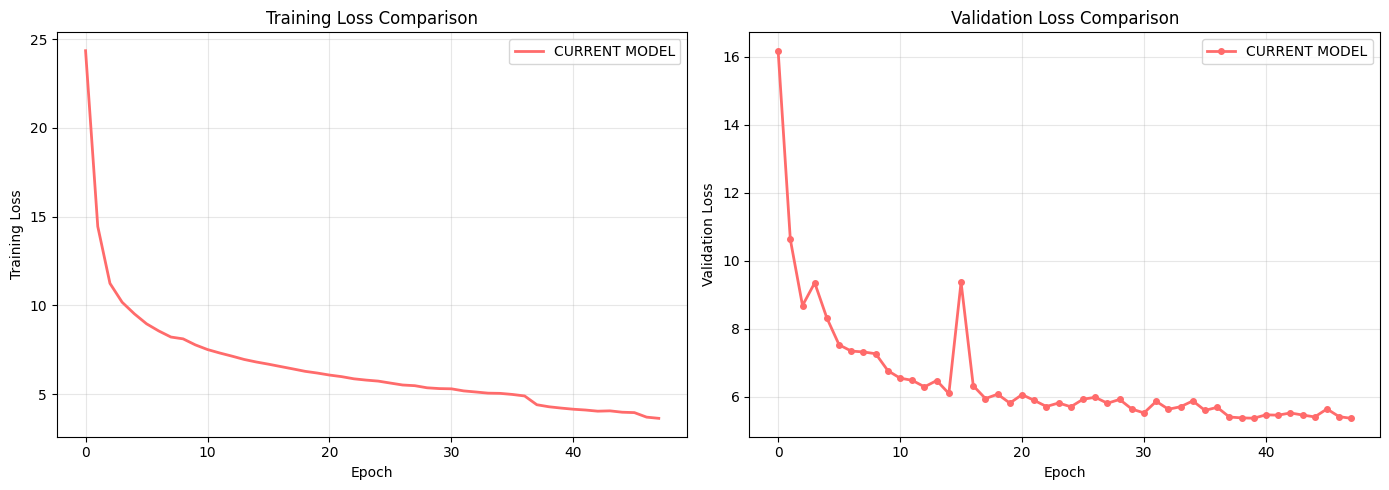

In [21]:
def plot_loss_comparison(models):
    """Plot training and validation loss curves for all models."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = ['#ff6b6b', '#4ecdc4', '#95e1d3', '#f38181']
    
    # Training loss
    for idx, model_eval in enumerate(models):
        if len(model_eval.train_losses) > 0:
            ax1.plot(model_eval.train_losses, 
                    label=model_eval.name.split('(')[0].strip(),
                    color=colors[idx % len(colors)],
                    linewidth=2)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Validation loss
    for idx, model_eval in enumerate(models):
        if len(model_eval.val_losses) > 0:
            ax2.plot(model_eval.val_losses,
                    label=model_eval.name.split('(')[0].strip(),
                    color=colors[idx % len(colors)],
                    linewidth=2,
                    marker='o',
                    markersize=4)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_loss_comparison(models)

## Improvement Analysis

In [22]:
def calculate_improvements(base_model, new_model, iou_threshold=0.5):
    """Calculate percentage improvements from base to new model."""
    
    metrics = ['precision', 'recall', 'f1', 'ap']
    improvements = {}
    
    print(f"\nIMPROVEMENTS @ IoU {iou_threshold}")
    print("="*70)
    print(f"Comparing: {base_model.name} → {new_model.name}")
    print("="*70)
    
    for metric in metrics:
        base_val = base_model.get_metric(metric, iou_threshold)
        new_val = new_model.get_metric(metric, iou_threshold)
        
        if base_val is not None and new_val is not None and base_val > 0:
            improvement = ((new_val - base_val) / base_val) * 100
            improvements[metric] = improvement
            
            print(f"{metric.upper():12s}: {base_val:.4f} → {new_val:.4f} ({improvement:+.1f}%)")
    
    return improvements

# Calculate improvements for both IoU thresholds
if len(models) >= 2:
    for iou_thresh in IOU_THRESHOLDS:
        improvements = calculate_improvements(models[0], models[1], iou_threshold=iou_thresh)
        print()


IMPROVEMENTS @ IoU 0.5
Comparing: CURRENT MODEL (λ_coord=7.5, with augmentation) → YOLOv5s Baseline
PRECISION   : 0.9618 → 0.9593 (-0.3%)
RECALL      : 0.9151 → 0.3930 (-57.1%)
F1          : 0.9379 → 0.5576 (-40.5%)
AP          : 0.8986 → 0.3624 (-59.7%)


IMPROVEMENTS @ IoU 0.85
Comparing: CURRENT MODEL (λ_coord=7.5, with augmentation) → YOLOv5s Baseline
PRECISION   : 0.4899 → 0.8251 (+68.4%)
RECALL      : 0.4661 → 0.3381 (-27.5%)
F1          : 0.4777 → 0.4796 (+0.4%)
AP          : 0.2775 → 0.3552 (+28.0%)



## Summary Statistics

In [23]:
print("\n" + "="*70)
print("OVERALL SUMMARY")
print("="*70)

for model_eval in models:
    print(f"\n{model_eval.name}")
    print("-" * 70)
    print(f"  Training: Epoch {model_eval.epoch}, Val Loss: {model_eval.val_loss}")
    print(f"  Best Performance (IoU 0.5):")
    print(f"    - mAP: {model_eval.get_metric('ap', 0.5):.4f}")
    print(f"    - F1:  {model_eval.get_metric('f1', 0.5):.4f}")
    print(f"  Best Performance (IoU 0.85):")
    print(f"    - mAP: {model_eval.get_metric('ap', 0.85):.4f}")
    print(f"    - F1:  {model_eval.get_metric('f1', 0.85):.4f}")


OVERALL SUMMARY

CURRENT MODEL (λ_coord=7.5, with augmentation)
----------------------------------------------------------------------
  Training: Epoch 48, Val Loss: 5.361270847854936
  Best Performance (IoU 0.5):
    - mAP: 0.8986
    - F1:  0.9379
  Best Performance (IoU 0.85):
    - mAP: 0.2775
    - F1:  0.4777

YOLOv5s Baseline
----------------------------------------------------------------------
  Training: Epoch N/A, Val Loss: N/A
  Best Performance (IoU 0.5):
    - mAP: 0.3624
    - F1:  0.5576
  Best Performance (IoU 0.85):
    - mAP: 0.3552
    - F1:  0.4796
